In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

%matplotlib inline

In [4]:
def synthetic_data():
    #mean1 = np.concatenate((np.ones(1)*-10,np.ones(12)))
    #mean2 = np.concatenate((np.ones(12),np.ones(1)*10))
    mean1 = np.ones(13)*7
    mean2 = np.ones(13)*10
    mean3 = np.ones(13)*5
    mean4 = np.ones(13)*8
    g1 = np.random.multivariate_normal(mean1, np.eye(13), size=55)
    g2 = np.random.multivariate_normal(mean2, np.eye(13), size=36)
    g3 = np.random.multivariate_normal(mean3, np.eye(13), size=35)
    g4 = np.random.multivariate_normal(mean4, np.eye(13), size=13)

    y1 = np.asarray([1]*55).reshape(55,1)
    y2 = np.asarray([2]*36).reshape(36,1)
    y3 = np.asarray([3]*35).reshape(35,1)
    y4 = np.asarray([4]*13).reshape(13,1)


    #y1 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y2 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y3 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)
    #y4 = np.random.choice(5, 297, p=[0.54, 0.18, 0.12, 0.12, 0.04]).reshape(297,1)

    g1 = np.concatenate((g1,y1), axis=1)
    g2 = np.concatenate((g2,y2), axis=1)
    g3 = np.concatenate((g3,y3), axis=1)
    g4 = np.concatenate((g4,y4), axis=1)

    g = np.concatenate([g1,g2,g3,g4], axis=0)

    d = pd.DataFrame(data=g, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
    return d

#d1 = pd.DataFrame(data=g1, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d2 = pd.DataFrame(data=g2, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d3 = pd.DataFrame(data=g3, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#d4 = pd.DataFrame(data=g4, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
#plt.scatter(g1[:,0], g1[:,1],g1[:,2], c='b')
#plt.scatter(g2[:,0], g2[:,1],g2[:,2], c='r')
#plt.scatter(g3[:,0], g3[:,1],g3[:,2], c='g')
#plt.scatter(g4[:,0], g4[:,1],g4[:,2], c='y')
#plt.show()

In [18]:
targetTests = []
scores = []
cms = []
probas_final = []
iterations = 10
data = synthetic_data()
for i in tqdm(range(iterations)):
    score, probas, cm = train_and_test(data)
    scores.append(score)
    probas_final.append(probas)
    cms.append(cm)
    
target = targetTests[np.argmax(scores)]
target = label_binarize(target, classes=[1,2,3,4])
proba = probas_final[np.argmax(scores)]
cm = cms[np.argmax(scores)]
np.savetxt("confusion_matrix_ova.csv", cm, delimiter=",")
scores = np.asarray(scores)
print('best score: %f' % scores.max())
print(scores.mean())
print(scores.std())

100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

best score: 0.821429
0.660714285714
0.0818317088385


In [5]:
#optimal cutpoints

#find the closest point to (0,1) coordinate
def roc01(fpr, tpr):
    tl = [0,1]
    index = None
    opt = np.inf
    for i in range(len(fpr)):
        d = np.linalg.norm(np.array(tl) - np.array([fpr[i], tpr[i]]))
        if d < opt:
            opt = d
            index = i
    return fpr[index], tpr[index]

#Youden's index
def youden_index(fpr, tpr):
    sp = 1-fpr
    se = tpr
    index = None
    opt = -1
    for i in range(len(fpr)):
        pt = sp[i]+se[i]
        if pt > opt:
            opt = pt
            index = i
            
    return fpr[index], tpr[index]
    
#maximize sensitivity
def max_se(fpr, tpr, threshold=1e-4):
    sp = 1-fpr
    se = tpr
    index = None
    opt_se = -1
    opt_sp = -1
    for i in range(len(fpr)):
        if se[i] > opt_se:
            opt_se = se[i]
            opt_sp = sp[i]
            index = i
        elif abs(se[i]-opt_se) <= threshold:
            if sp[i] > opt_sp:
                opt_se = se[i]
                opt_sp = sp[i]
                index = i
    return fpr[index], tpr[index]

#maximize specificity
def max_sp(fpr, tpr, threshold=1e-4):
    sp = 1-fpr
    se = tpr
    index = None
    opt_se = -1
    opt_sp = -1
    for i in range(len(fpr)):
        if sp[i] > opt_sp:
            opt_se = se[i]
            opt_sp = sp[i]
            index = i
        elif abs(sp[i]-opt_sp) <= threshold:
            if se[i] > opt_se:
                opt_se = se[i]
                opt_sp = sp[i]
                index = i
    return fpr[index], tpr[index]
                

In [23]:
data = synthetic_data()

## split data into train and test
cols = list(data.columns)
cols.remove('num')
target = data['num'].copy()
input_data = data[cols].copy()
#target_bin = label_binarize(target, classes=[0, 1, 2, 3, 4])
#test removing healthy patients
dTrain, dTest, targetTrain, targetTest = train_test_split(input_data, target, test_size=0.20, stratify=target)
scaler = preprocessing.StandardScaler().fit(dTrain)
dTrain = scaler.transform(dTrain)
ovr = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced', random_state=0), n_jobs=-1)
ovr.fit(dTrain, targetTrain)

dTest = scaler.transform(dTest)
targetTest = label_binarize(targetTest, classes=[1, 2, 3, 4])
probas = ovr.predict_proba(dTest)
print(probas.max(axis=1))
pred = ovr.predict(dTest)
print(pred, pred.shape)

cutpoints_preds = np.zeros(shape=(probas.shape[0],))
#test removing healthy patients

[ 0.66594969  0.66126296  0.64931817  0.65425224  0.6618949   0.62524944
  0.82938328  0.8734889   0.67240922  0.67162058  0.86861216  0.69445884
  0.82230623  0.68271909  0.72531972  0.64987262  0.67879147  0.56937653
  0.66563993  0.82055888  0.69322416  0.68710558  0.64486099  0.71141208
  0.66013869  0.85474746  0.64611215  0.66811072]
[ 1.  4.  2.  1.  4.  1.  1.  4.  1.  4.  4.  3.  1.  1.  4.  1.  4.  1.
  4.  1.  1.  1.  3.  4.  4.  4.  3.  1.] (28,)


Youden optimal cutpoint

[ 0.8734889   0.82055888  0.69322416  0.56937653  0.21888641]
0.693224160956


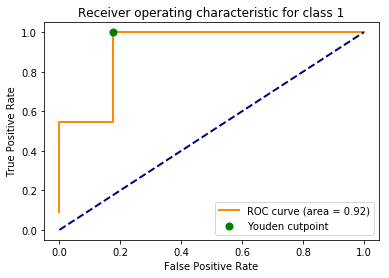

[  6.78791466e-01   6.49318174e-01   6.35438283e-06]
0.64931817408


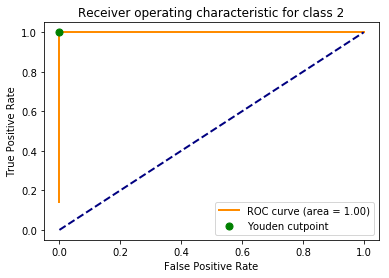

[  6.94458838e-01   6.44860987e-01   3.19376773e-07]
0.644860987042


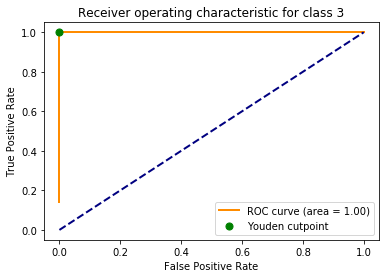

[ 1.37248975  0.37248975  0.2484473   0.22355008  0.12308599  0.1191716
  0.06119152  0.06017603  0.01292072]
0.123085994369


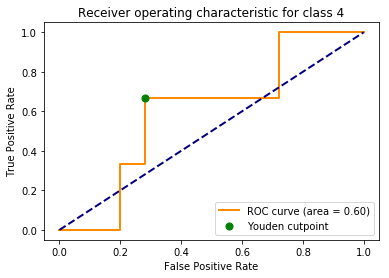

In [27]:
#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
cutpoints = dict()
#for i in range(5):
#test removing healthy patients
for i in range(4):
    fpr[i], tpr[i], thresholds[i] = roc_curve(targetTest[:, i], probas[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#for i in range(5):
#test removing healthy patients
for i in range(4):
    opt_cutpoint = youden_index(fpr[i], tpr[i])
    cutpoints[i] = thresholds[i][np.where(fpr[i] == opt_cutpoint[0])[0][0]]
    print(thresholds[i])
    c_index = np.where(fpr[i] == opt_cutpoint[0])[0][0]
    if c_index == 0:
        c_index += 1
    print(thresholds[i][c_index])
    fig, ax = plt.subplots()
    lw = 2
    ax.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i], zorder=-1)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', zorder=-1)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class ' + str(i+1))
    ax.scatter(opt_cutpoint[0], opt_cutpoint[1], c='g', zorder=1, label='Youden cutpoint', s=50)
    ax.legend(loc="lower right")
    plt.show()

cutpoints_preds = np.zeros(shape=(probas.shape[0],))


ROC01

0.716702924715


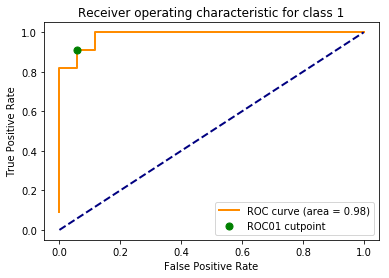

0.68000747787


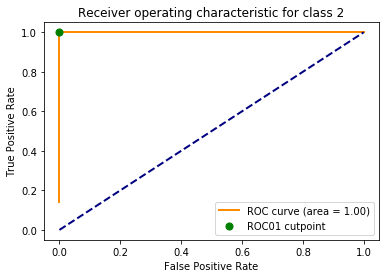

0.666973690968


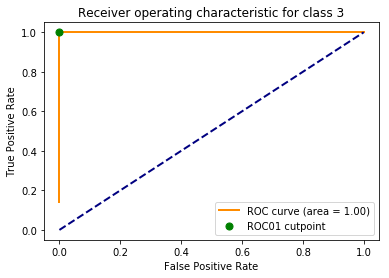

0.14905804295


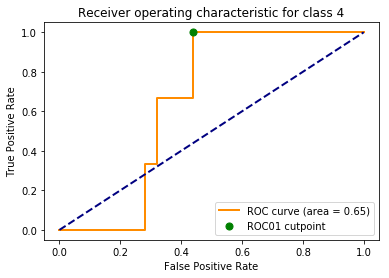

In [39]:
#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
#for i in range(5):
#test removing healthy patients
for i in range(4):
    fpr[i], tpr[i], thresholds[i] = roc_curve(target[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#for i in range(5):
#test removing healthy patients
for i in range(4):
    opt_cutpoint = roc01(fpr[i], tpr[i])
    print(thresholds[i][np.where(fpr[i] == opt_cutpoint[0])[0][0]])
    fig, ax = plt.subplots()
    lw = 2
    ax.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i], zorder=-1)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', zorder=-1)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class ' + str(i+1))
    ax.scatter(opt_cutpoint[0], opt_cutpoint[1], c='g', zorder=1, label='ROC01 cutpoint', s=50)
    ax.legend(loc="lower right")
    plt.show()

Maximize sensitivity

0.683273265308


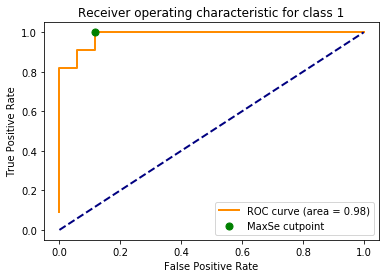

0.68000747787


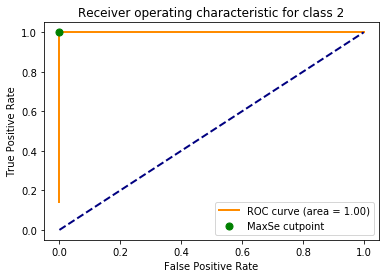

0.666973690968


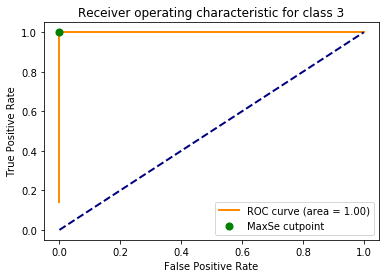

0.14905804295


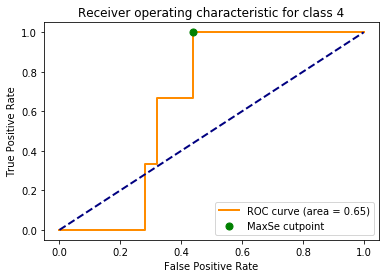

In [40]:
#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
#for i in range(5):
#test removing healthy patients
for i in range(4):
    fpr[i], tpr[i], thresholds[i] = roc_curve(target[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#for i in range(5):
#test removing healthy patients
for i in range(4):
    opt_cutpoint = max_se(fpr[i], tpr[i])
    print(thresholds[i][np.where(fpr[i] == opt_cutpoint[0])[0][0]])
    fig, ax = plt.subplots()
    lw = 2
    ax.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i], zorder=-1)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', zorder=-1)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class ' + str(i+1))
    ax.scatter(opt_cutpoint[0], opt_cutpoint[1], c='g', zorder=1, label='MaxSe cutpoint', s=50)
    ax.legend(loc="lower right")
    plt.show()

Maximize specificity

[ 0.78606819  0.74669627  0.71670292  0.7100714   0.68327327  0.6600247
  0.25314516]
0.786068186447


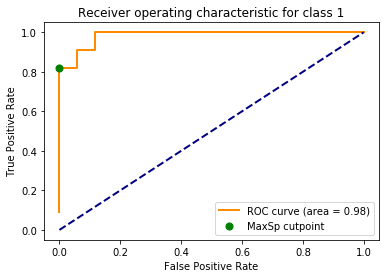

[  6.80007478e-01   6.37675055e-01   1.01402861e-05]
0.68000747787


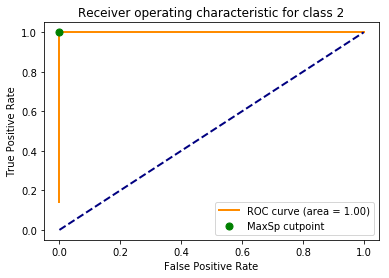

[  6.66973691e-01   3.91602218e-01   3.20515476e-07]
0.666973690968


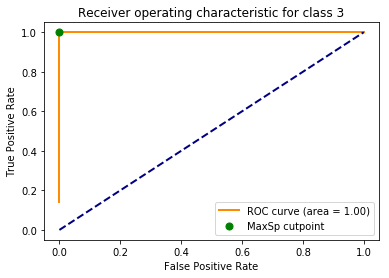

[ 1.18465462  0.18465462  0.17175552  0.17145989  0.17012962  0.16546852
  0.14905804  0.12525475  0.06089311]
1.18465461969


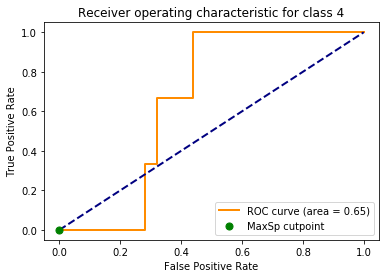

In [41]:
#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
#for i in range(5):
#test removing healthy patients
for i in range(4):
    fpr[i], tpr[i], thresholds[i] = roc_curve(target[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#for i in range(5):
#test removing healthy patients
for i in range(4):
    print(thresholds[i])
    opt_cutpoint = max_sp(fpr[i], tpr[i])
    print(thresholds[i][np.where(fpr[i] == opt_cutpoint[0])[0][0]])
    fig, ax = plt.subplots()
    lw = 2
    ax.plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i], zorder=-1)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', zorder=-1)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class ' + str(i+1))
    ax.scatter(opt_cutpoint[0], opt_cutpoint[1], c='g', zorder=1, label='MaxSp cutpoint', s=50)
    ax.legend(loc="lower right")
    plt.show()

In [15]:
ova = pd.read_csv('confusion_matrix_ova.csv', header=None)
print(ova)

      0    1    2    3
0  11.0  0.0  0.0  0.0
1   0.0  7.0  0.0  0.0
2   3.0  0.0  4.0  0.0
3   2.0  0.0  0.0  1.0
